# Self-Driving Car Engineer Nanodegree


## Project: **Project 4 - Advanced Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
%matplotlib inline

## Calibrate camera

In [2]:
# prepare object points
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# termination criteria for subpixel searchh for corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# iterate through all calibration images and search for corners
for file in os.listdir("camera_cal/"):
    # Read image
    img = mpimg.imread('camera_cal/' + file)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, append the image and object points to respective lists
    if ret == True:
        objpoints.append(objp)       
        # improve the precision of corners to subpixel level
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

# Calculate the camera calibration paramteters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

### Show undistortion using calculated calibration

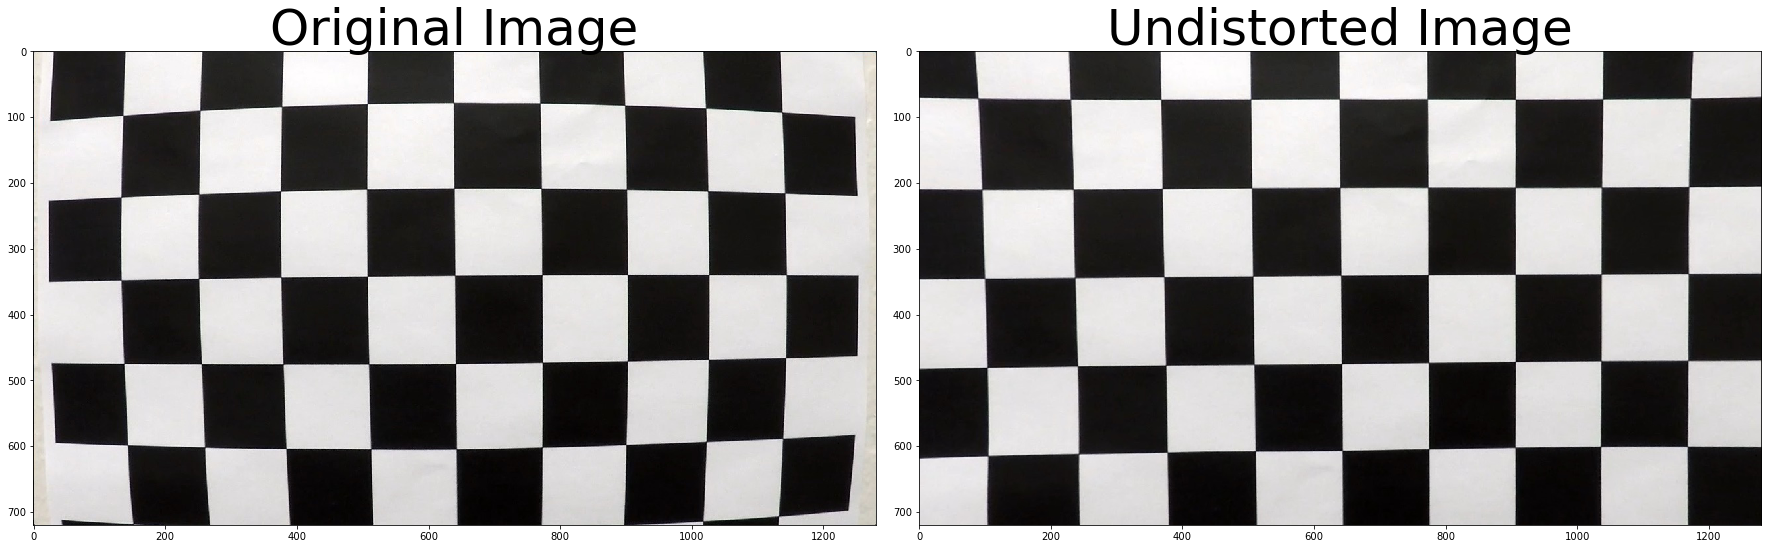

In [3]:
# Load calibration image
img = mpimg.imread('camera_cal/calibration1.jpg')
# Remove distortion
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Show undistortion on real image

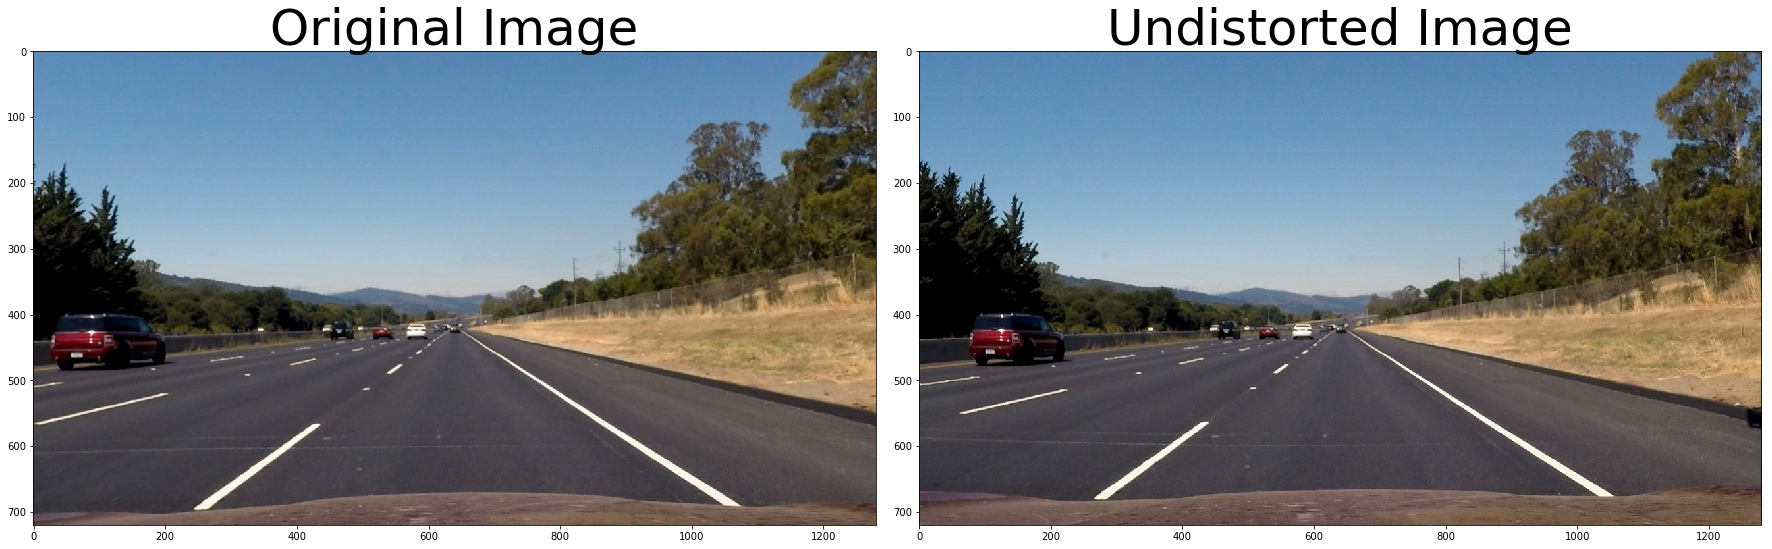

In [4]:
# Load random test image
img = mpimg.imread('test_images/' + os.listdir("test_images/")[np.random.randint(0,len(os.listdir("test_images/")))])
# Undistort it
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

#Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Mask out the likely line pixels

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def lane_binary(image):
    """
    This function detects lane markings
    """
    
    ## Convert image to HSL color spaces
    output = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # Filter for bright values in L component
    white = cv2.threshold(output[:,:,1],200,255,cv2.THRESH_BINARY)[1]
    # Extra yellow filter - Filter for high values in Lab B channel
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    # Normalize the b channel
    if np.max(lab[:,:,2]) > 175:
        lab[:,:,2] = lab[:,:,2]*(255/np.max(lab[:,:,2]))
    yellow = cv2.threshold(lab[:,:,2],190,255,cv2.THRESH_BINARY)[1]
    # Combine the two filters
    output = cv2.bitwise_or(white, yellow)

    
    ## Perform morphological closing on the image
    # Define kernel for the morpholocical operations
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    # Dilate the image
    output = cv2.dilate(output, element, iterations=1)
    # Erode the image
    output = cv2.erode(output, element, iterations=1)
    
    # Define top of the ROI at 60% of image height
    top_roi = int(0.6*image.shape[0])
    # Define vertices of ROI trapezoid
    vertices = np.array([[0,image.shape[0]],[int(0.45*image.shape[1]), top_roi], 
                         [int(0.55*image.shape[1]), top_roi], [image.shape[1],image.shape[0]]])
    # Mask the ROI
    output = region_of_interest(output, [vertices])
    return output

### Show detected likely lane line pixels

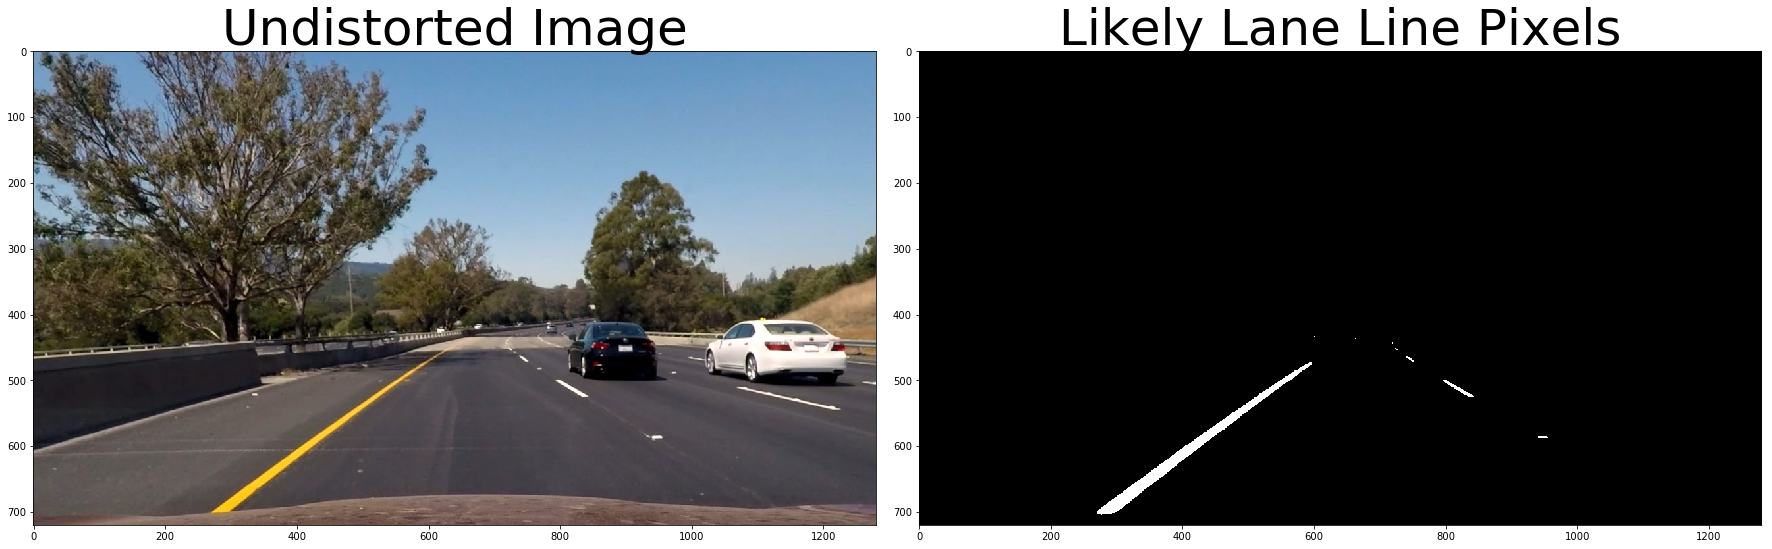

In [6]:
img = mpimg.imread('test_images/' + os.listdir("test_images/")[np.random.randint(0,len(os.listdir("test_images/")))])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
detected = lane_binary(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(detected, cmap='gray')
ax2.set_title('Likely Lane Line Pixels', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform

### Function for birdview transform

In [7]:
def to_birdview(img, src, dst):
    """
    Transforms image to birdview perspective
    """
    # Transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

### Confirming the transform source and destination points

This bit of code was used to search for ideal transform points on straight lines images.

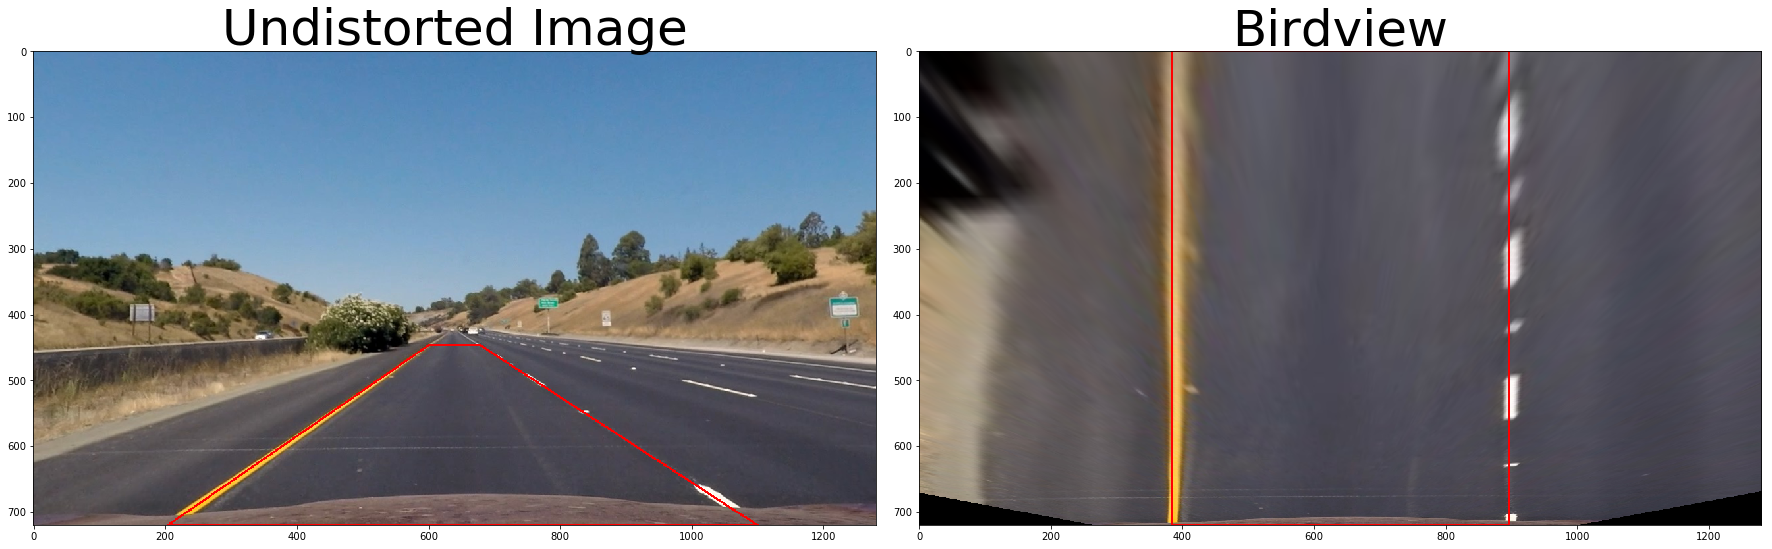

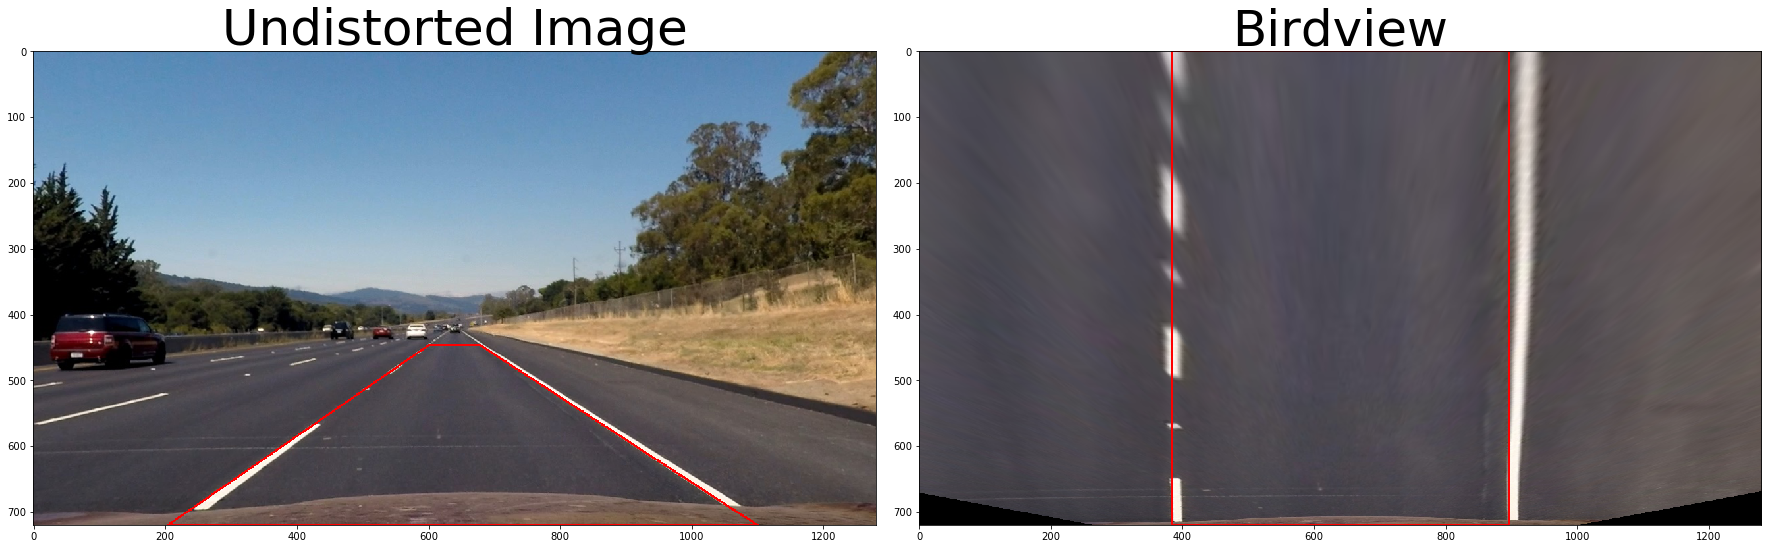

In [8]:
# Define source and destination points for transormation
# experimentation with source and destination points for transform
top = int(0.62*img.shape[0])
srcplt = np.array([[int(0.16*img.shape[1]),img.shape[0]],
                [int(0.47*img.shape[1]), top], 
                [int(0.53*img.shape[1]), top], 
                [int(0.86*img.shape[1]),img.shape[0]]])
dstplt = np.array([[int(0.3*img.shape[1]),img.shape[0]],
                [int(0.3*img.shape[1]), 0], 
                [int(0.7*img.shape[1]), 0], 
                [int(0.7*img.shape[1]),img.shape[0]]])

src = np.float32(srcplt)
dst = np.float32(dstplt)

# Load test image with straight lines, undistor it and tranform to birdview
img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
detected = lane_binary(undistorted)
birdview = to_birdview(undistorted, src, dst)

# Plot the points that define the tranformation
undistorted = cv2.polylines(undistorted, [srcplt], isClosed=True, color=(255,0,0), thickness=2)
birdview = cv2.polylines(birdview, [dstplt], isClosed=True, color=(255,0,0), thickness=2)

# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(birdview, cmap='gray')
ax2.set_title('Birdview', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Repeat for second test image with straight lines
img = mpimg.imread('test_images/straight_lines2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
detected = lane_binary(undistorted)
birdview = to_birdview(undistorted, src, dst)
undistorted = cv2.polylines(undistorted, [srcplt], isClosed=True, color=(255,0,0), thickness=2)
birdview = cv2.polylines(birdview, [dstplt], isClosed=True, color=(255,0,0), thickness=2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(birdview, cmap='gray')
ax2.set_title('Birdview', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

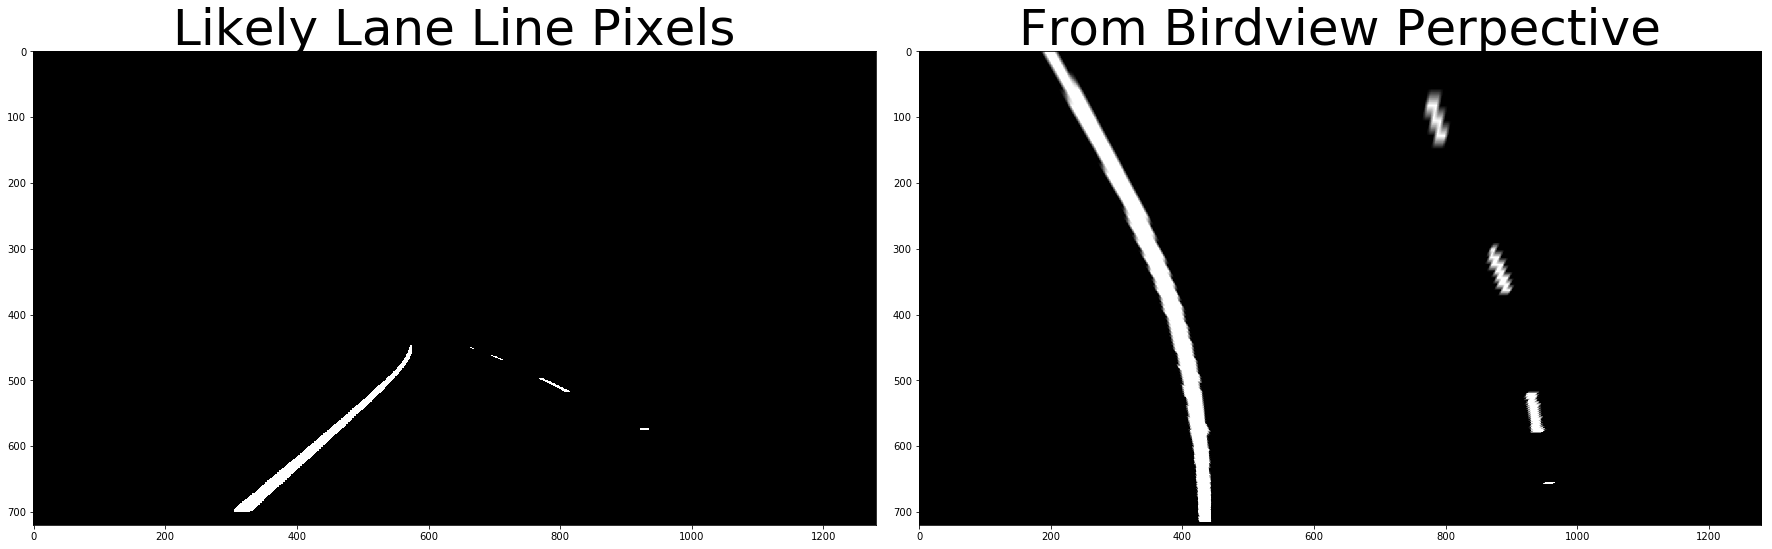

In [9]:
# Load random test image, undistort it, detect lanes and transform to birdview
img = mpimg.imread('test_images/' + os.listdir("test_images/")[np.random.randint(0,len(os.listdir("test_images/")))])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
detected = lane_binary(undistorted)
birdview = to_birdview(detected, src, dst)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(detected, cmap='gray')
ax1.set_title('Likely Lane Line Pixels', fontsize=50)
ax2.imshow(birdview, cmap='gray')
ax2.set_title('From Birdview Perpective', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Search for polynomial represantation of the lanes, lane curvature and centering of vehicle

In [10]:
def fit_lanes(img):
    #TODO: Better search, when previous lane location is known. Set up a prevoius lane as an input
    
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Calculate curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = (2*40*0.3)/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/(0.4*1280) # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = 720
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate the position of camera between the lanes
    centering = xm_per_pix*((np.polyval(right_fit, y_eval) + np.polyval(left_fit, y_eval) - img.shape[1])/2)
    
    
    
    
    # return fit coefficients, curvature radii and the centering value
    return left_fit, right_fit, left_curverad, right_curverad, centering

### Test the fitting function

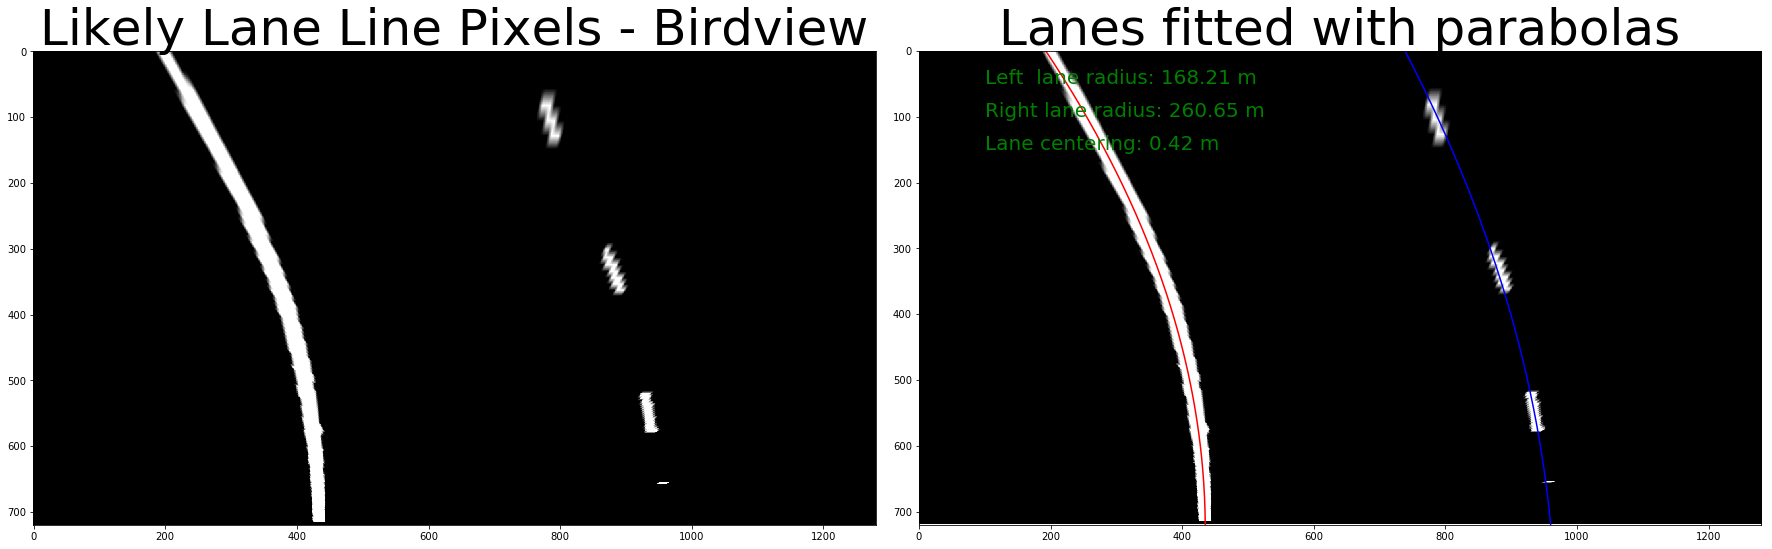

In [11]:
# Load image, undistort it, detect lane pixels, transfrom to birdview and fit with parabolas
img = mpimg.imread('test_images/' + os.listdir("test_images/")[np.random.randint(0,len(os.listdir("test_images/")))])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
detected = lane_binary(undistorted)
birdview = to_birdview(detected, src, dst)
left_fit, right_fit, left_curverad, right_curverad, centering = fit_lanes(birdview)

# Generate x and y values for plotting
ploty = np.linspace(0, birdview.shape[0]-1, birdview.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(birdview, cmap='gray')
ax1.set_title('Likely Lane Line Pixels - Birdview', fontsize=50)
ax2.imshow(birdview, cmap='gray')
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='blue')
plt.text(100, 50, 'Left  lane radius: %.2f m' %left_curverad, color='green', fontsize=20)
plt.text(100, 100, 'Right lane radius: %.2f m' %right_curverad, color='green', fontsize=20)
plt.text(100, 150, 'Lane centering: %.2f m' %centering, color='green', fontsize=20)
plt.xlim(0, 1280)
plt.ylim(720, 0)
ax2.set_title('Lanes fitted with parabolas', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Show lanes in original image

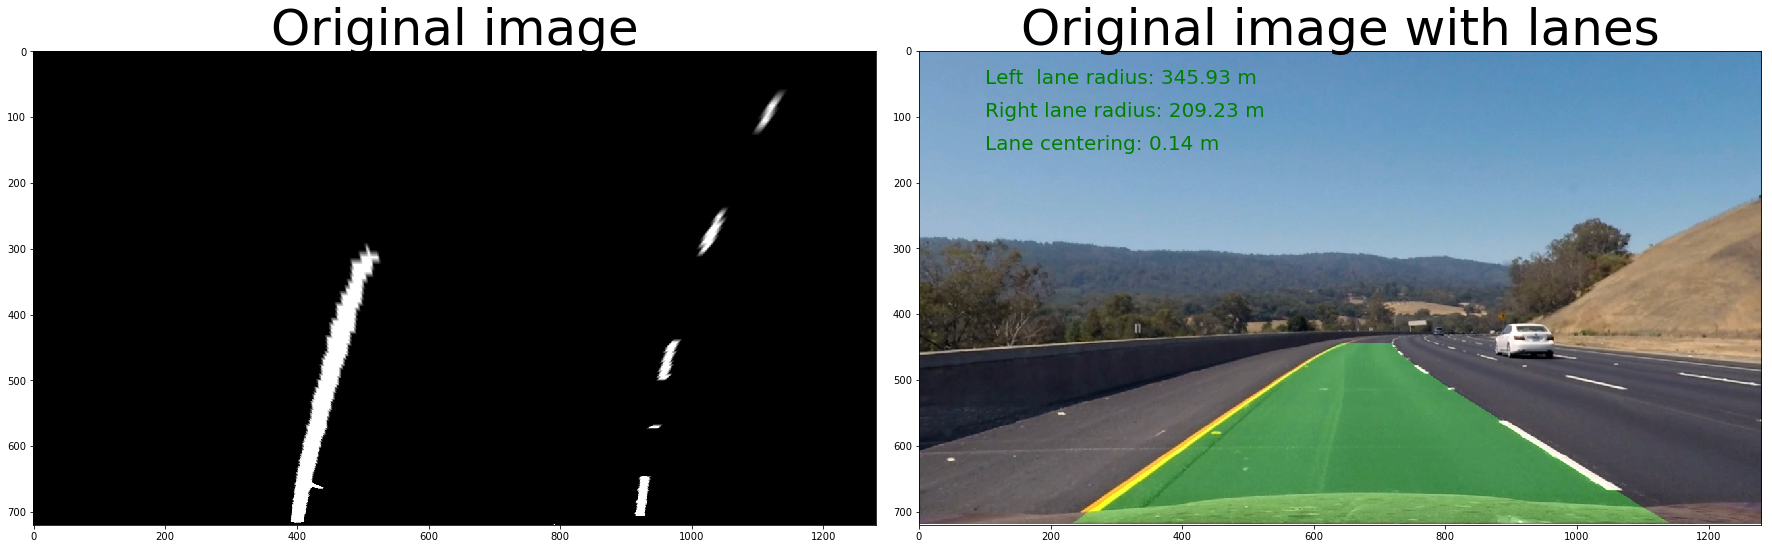

In [12]:
img = mpimg.imread('test_images/' + os.listdir("test_images/")[np.random.randint(0,len(os.listdir("test_images/")))])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
detected = lane_binary(undistorted)
birdview = to_birdview(detected, src, dst)
left_fit, right_fit, left_curverad, right_curverad, centering = fit_lanes(birdview)

# Generate x and y values for plotting
ploty = np.linspace(0, birdview.shape[0]-1, birdview.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw the lines on
warp_zero = np.zeros_like(birdview).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
# Reverse transformation matrix
Minv = cv2.getPerspectiveTransform(dst, src)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 



# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(birdview, cmap='gray')
ax1.set_title('Original image', fontsize=50)
ax2.imshow(result)
plt.text(100, 50, 'Left  lane radius: %.2f m' %left_curverad, color='green', fontsize=20)
plt.text(100, 100, 'Right lane radius: %.2f m' %right_curverad, color='green', fontsize=20)
plt.text(100, 150, 'Lane centering: %.2f m' %centering, color='green', fontsize=20)
plt.xlim(0, 1280)
plt.ylim(720, 0)
ax2.set_title('Original image with lanes', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Line class

In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.fit_list = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
    def new_fit(self, fit):
        # add new fit to the line
        self.fit_list.append(fit)
        # Smooth over last 10 detections
        if len(self.fit_list) > 10:
            # throw out old fits, keep newest n
            self.fit_list = self.fit_list[len(self.fit_list)-10:]
        self.best_fit = np.average(self.fit_list, axis=0)



# Lane finding pipeline

In [14]:
def detect_lanes(img):
    top = int(0.62*img.shape[0])
    srcplt = np.array([[int(0.16*img.shape[1]),img.shape[0]],
                    [int(0.47*img.shape[1]), top], 
                    [int(0.53*img.shape[1]), top], 
                    [int(0.86*img.shape[1]),img.shape[0]]])
    dstplt = np.array([[int(0.3*img.shape[1]),img.shape[0]],
                    [int(0.3*img.shape[1]), 0], 
                    [int(0.7*img.shape[1]), 0], 
                    [int(0.7*img.shape[1]),img.shape[0]]])

    src = np.float32(srcplt)
    dst = np.float32(dstplt)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    detected = lane_binary(undistorted)
    birdview = to_birdview(detected, src, dst)
    left_fit, right_fit, left_curverad, right_curverad, centering = fit_lanes(birdview)

    #Update the left and right lane properties
    l_line.radius_of_curvature = left_curverad
    r_line.radius_of_curvature = right_curverad
    l_line.new_fit(left_fit)
    r_line.new_fit(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, birdview.shape[0]-1, birdview.shape[0] )
    left_fitx = l_line.best_fit[0]*ploty**2 + l_line.best_fit[1]*ploty + l_line.best_fit[2]
    right_fitx = r_line.best_fit[0]*ploty**2 + r_line.best_fit[1]*ploty + r_line.best_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(birdview).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    # Calculate mean curvature and display its value in overlay text
    mean_curverad = (l_line.radius_of_curvature + r_line.radius_of_curvature)/2
    if mean_curverad>1000:
        result = cv2.putText(result, 'Lane radius: straight', (100, 50), 0, 1, (0, 255, 0), 2, 20)            
    else:
        result = cv2.putText(result, 'Lane radius: %.0f m' %right_curverad, (100, 50), 0, 1, (0, 255, 0), 2, 20)

    # Display lane centering value in overlay
    result = cv2.putText(result, 'Lane centering: %.2f m' %centering, (100, 100), 0, 1, (0, 255, 0), 2, 20)
    return result

    

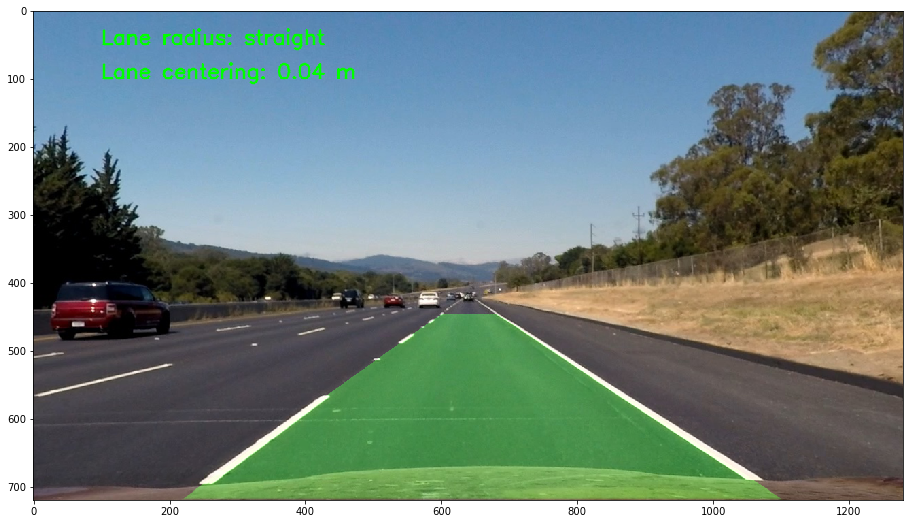

In [15]:
img = mpimg.imread('test_images/' + os.listdir("test_images/")[np.random.randint(0,len(os.listdir("test_images/")))])
l_line = Line()
r_line = Line()
result = detect_lanes(img)
plt.figure(figsize=(24, 9))
plt.imshow(result)
plt.show()

#undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#detected = lane_binary(undistorted)
#birdview = to_birdview(detected, src, dst)
#left_fit, right_fit, left_curverad, right_curverad, centering = fit_lanes(birdview)

# Generate x and y values for plotting
#ploty = np.linspace(0, birdview.shape[0]-1, birdview.shape[0] )
#left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#plt.figure(figsize=(24,18))
#plt.subplot(221)
#undistorted = cv2.polylines(undistorted, [srcplt], isClosed=True, color=(255,0,0), thickness=2)
#plt.imshow(undistorted)
#plt.subplot(222)
#detected = cv2.cvtColor(detected, cv2.COLOR_GRAY2RGB)
#detected = cv2.polylines(detected, [srcplt], isClosed=True, color=(255,0,0), thickness=2)
#plt.imshow(detected)
#plt.subplot(223)
#birdview = cv2.cvtColor(birdview, cv2.COLOR_GRAY2RGB)
#birdview = cv2.polylines(birdview, [dstplt], isClosed=True, color=(255,0,0), thickness=2)
#plt.plot(left_fitx, ploty, color='blue')
#plt.plot(right_fitx, ploty, color='blue')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)
#plt.imshow(birdview)
#plt.subplot(224)
#plt.imshow(detect_lanes(img))

## Test on Videos

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
l_line = Line()
r_line = Line()
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detect_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:12<00:00,  6.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 14s
